# Understanding Denoising Diffusion Probabilistic Models (DDPM)

This Jupyter Notebook is derived from a notebook by deepfindr@gmail.com, their [notebook](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbHZUU3UycnAyTmgwWks2QWVKZjROYjNfellaQXxBQ3Jtc0ttaEJkYXhIZGlqdlFEcEZIYmZxYTVqRTlVZ2ZyQldfM3ZTX2tBYzRyUXRwZUs2Y2pLTW15TlpTekZUYmdvd200eGprNk1oTkRMWlNrbGRDV1FLNklwNkxiOXJ0QU5iaFdsUFVaMm1LNlJ0US1EQmJvYw&q=https%3A%2F%2Fcolab.research.google.com%2Fdrive%2F1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL%3Fusp%3Dsharing&v=a4Yfz2FxXiY) can be found in the description of their YouTube [video](https://youtu.be/a4Yfz2FxXiY?si=sRHWekx6D0esnGZJ) about DDPM and it helped me to better understand the logic behing the model and how it is capable of generating images. I recommend watching it.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from torch import nn
import math
from torch.optim import Adam

On the original notebook, they used the StanfordCars dataset, which is not available anymore in the recent version of torchvision. For this reason, I used STL10 dataset and used only the cars imagem for training the model.

The function show_images display some sample from the dataset after applying a mask to retrieve only the cars.

100%|██████████| 2640397119/2640397119 [08:20<00:00, 5270355.20it/s]


Extracting ./stl10_binary.tar.gz to .
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
total cars: 500


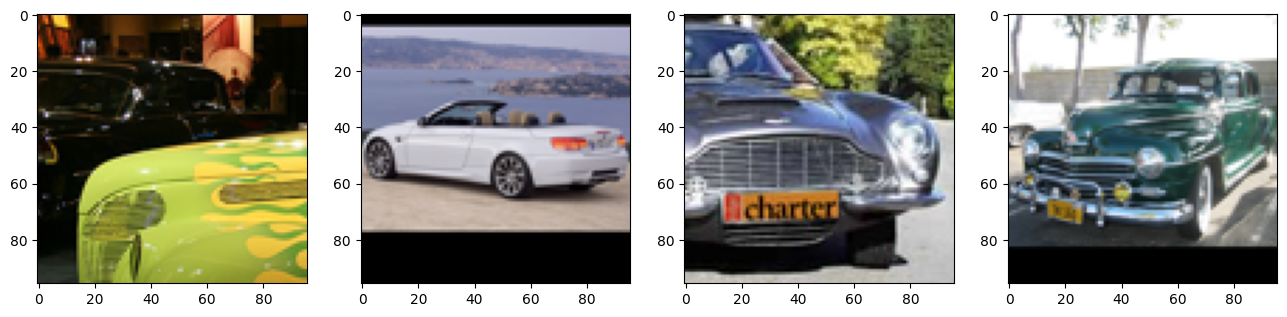

In [2]:
def show_images(dataset, num_samples=4, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(16,8))
    for i in range(num_samples):
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        img = dataset[i].transpose(1,2,0) # change axis order from c,row,col to row,col,c
        plt.imshow(img)

data = torchvision.datasets.STL10(root=".", download=True)
print(data.classes) # class car is label 2
mask = data.labels == 2
print("total cars:", sum(mask))
cars = data.data[mask]
show_images(cars)

This is a helpful function used during forward diffusion and reverse process. Function get_index_from_list return the value of a tensor list.

In [3]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu()) # gets vals[t]
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) # reshape output to (batch, 1, 1, 1), because x_shape is len of (batch,channel,lines,columns) - 1 = 3

The logic behind Diffusion models is that the Deep Learning model learn how to extract the noise from a noise image, as a result, generating a new image from pure noise.
The input for the model is noise image with different levels of noise. The input images used for training are generated by the forward process represented by this function forward_diffusion_sample.

This is the mathematically simplified equation of the diffusion process that add noise to the image: $x_t=\sqrt{\overline{\alpha}_t}x_0+\sqrt{1-\overline{\alpha}_t}\epsilon$

In [4]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) # epsilon
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape) # mean term will be multiplied with the image in the batch
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    ) # variance term will be multiplied with the noise (epsilon) in the batch
    # mean*x0 + variance*noise
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device) # return the noise batch images and the noise batch



The function linear_beta_schedule create a list of betas which is the increasing variance over t.

In [5]:
# Define beta schedule
# beta is the variance schedule. The variance increases over the time t
T = 300
betas = torch.linspace(0.0001, 0.02, T) # similar to np.linspace

# Pre-calculate different terms for closed form
# sqrt alpha is the mean that depends on beta. The mean decreases as beta increases over t
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # mean term used in the forward process
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # adds 1 in front and exclude last
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # used in the reverse process
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # used in the forward process
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # variance term used in the forward process
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # term used in the reverse process

The original images from the STL10 datasets were 96x96, but due to limited computation capabilities, I left the size 64 as in the original notebook.

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128

This part of the code, the proper transformation are applied to the train and test dataset. Both are then concatenated and only the car subset is used for the dataloader.

In [7]:
data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
]
data_transform = transforms.Compose(data_transforms)

train = torchvision.datasets.STL10(root=".", download=True,
                                     transform=data_transform) # get the train set and apply the transformation
test = torchvision.datasets.STL10(root=".", download=True,
                                     transform=data_transform, split='test') # get the test set and apply the transformation
data = torch.utils.data.ConcatDataset([train, test]) # concatenate the train and test data

mask = [i for i in range(len(data)) if data[i][1] == 2] # get indices of cars from the whole dataset
print("cars total:", len(mask))
data = Subset(data, mask) # get only the cars subset of the whole dataset
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified
cars total: 1300


In [8]:
def show_tensor_image(image):
    """
    Axiliary function to visualize image after converting it from tensor to PIL image
    """
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

This snipped of code takes on image from the dataset and apply noise to it at different ts.

<ipython-input-9-50f2a7bf4911>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


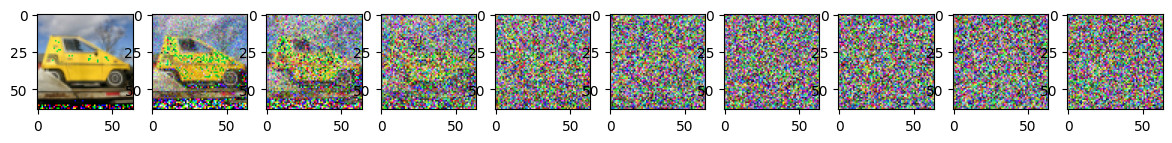

In [9]:
# Simulate forward diffusion
image = next(iter(dataloader))[0] # return images and labels

plt.figure(figsize=(16,2))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

An important element on the deep learning architecture is the time embedded layer.

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time): # time is the input
        device = time.device
        half_dim = self.dim // 2
        k = torch.arange(half_dim, device=device)
        k.repeat_interleave(2)
        w = 1/torch.pow(10000, 2*k/32)
        embeddings = w.repeat_interleave(2)
        embeddings = time[:, None] * embeddings[None, :] # torch.Size([300, 1]) * torch.Size([1, 32])
        embeddings = torch.where(torch.arange(2*half_dim, device=device) % 2 == 0, embeddings.sin(), embeddings.cos())
        return embeddings

For each time, this layer returns a unique 32 dimention vector. The rows on the image show the output for a sequence of time from 0 to 300. The x-axis is the respective vector.

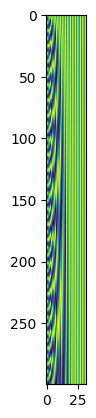

In [11]:
time_emb = nn.Sequential(
                SinusoidalPositionEmbeddings(32), # input 32
            )
t = torch.arange(300)
t = time_emb(t)
plt.imshow(t)

Here, I show how the concatenation of the time embedded layer with the convoluted image is done.

In [12]:
conv = nn.Conv2d(3, 4, 3, 1) # out_ch is 2
a = torch.arange(10*10*3, dtype=torch.float)
a = torch.reshape(a, (3,10,10))
a = conv(a)
a.shape

torch.Size([4, 8, 8])

In [13]:
b = torch.arange(4, dtype=torch.float)
b = b[(...,)+(None,)*2]
print(b)
b.shape

tensor([[[0.]],

        [[1.]],

        [[2.]],

        [[3.]]])


torch.Size([4, 1, 1])

In [14]:
c = a + b
c.shape

torch.Size([4, 8, 8])

In [15]:
a[3]-c[3]

tensor([[-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.]], grad_fn=<SubBackward0>)

This is the individual block of U-Net that can increase or decrease the convoluted image dimension.

In [16]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch) # input 32, output channel
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2] # torch.Size([batch, out_ch, 1, 1])
        # Add time channel
        h = h + time_emb # each time_mlp output is added to the respective conv channel
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

The SinusoidalPositionEmbeddings and the Block are put together in this SimpleUnet model.

In [17]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    Input is a noisy image, the ouput the noise in the image
    Timestep is encoded by the transformer Sinusoidal Embedding
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim), # input size 32, returns 32 dimention vector
                nn.Linear(time_emb_dim, time_emb_dim), # mlp with input size 32, output size 32
                nn.ReLU() # activation layer
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

This is the reverse process of the diffusion model: $x_{t-1}={1\over\sqrt{\alpha_t}}(x_t-{1-\alpha_t\over\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t))+\sigma_tz$

In [18]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape) # 1-alpha
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    ) # bottom part multiplied by the expected noise
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape) # term multiplied by the difference of previous image and estimated noise

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

Plot the sequence of images during the reverse process. It starts with noise and gradually the newly generated image becomes clear.

In [22]:
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for j in range(num_images):
      img = torch.randn((1, 3, img_size, img_size), device=device)
      for i in range(T-1,0,-1):
          t = torch.full((1,), i, device=device, dtype=torch.long)
          img = sample_timestep(img, t)
          # Edit: This is to maintain the natural range of the distribution
          img = torch.clamp(img, -1.0, 1.0)
      plt.subplot(1, num_images, j+1)
      show_tensor_image(img.detach().cpu())
    plt.show()

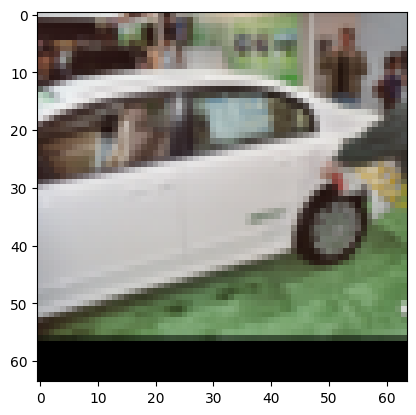

In [23]:
show_tensor_image(image[10])

Training phase:

Epoch 0 | step 000 Loss: 0.747465968132019 


<ipython-input-22-0cb9edb0f0bd>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, j+1)


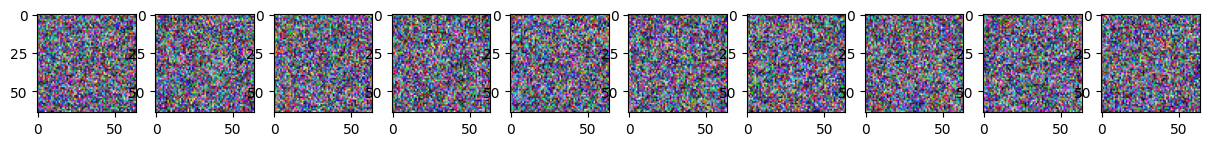

Epoch 20 | step 000 Loss: 0.21227633953094482 


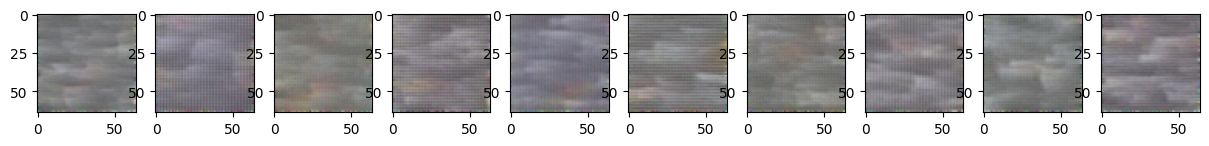

Epoch 40 | step 000 Loss: 0.17909257113933563 


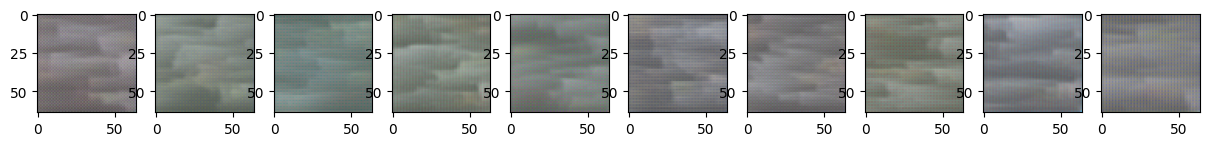

Epoch 60 | step 000 Loss: 0.16205132007598877 


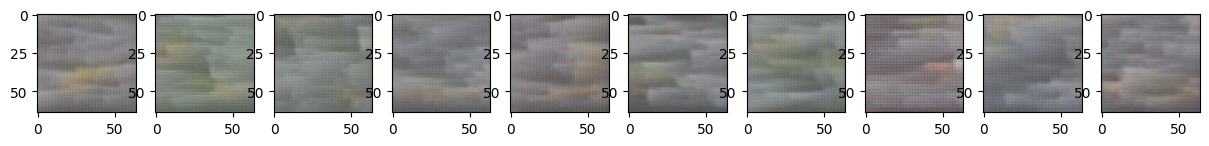

Epoch 80 | step 000 Loss: 0.15236735343933105 


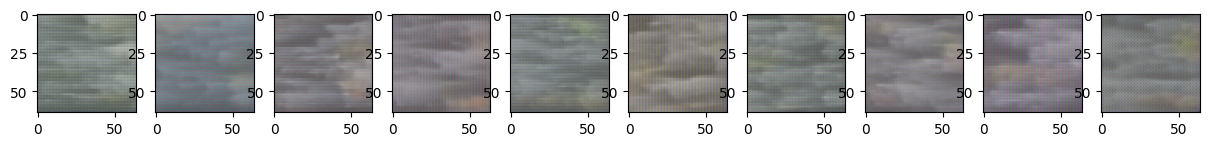

Epoch 100 | step 000 Loss: 0.15919004380702972 


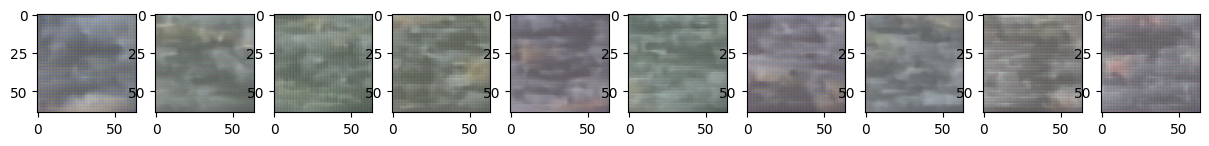

Epoch 120 | step 000 Loss: 0.16108527779579163 


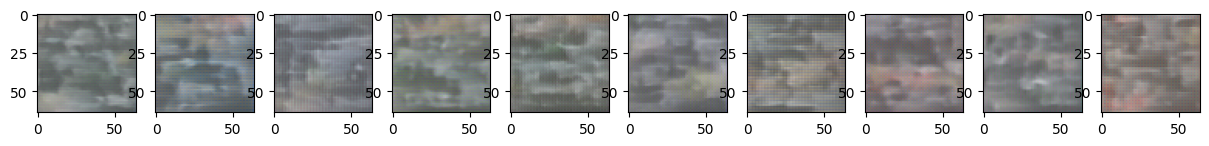

Epoch 140 | step 000 Loss: 0.15799441933631897 


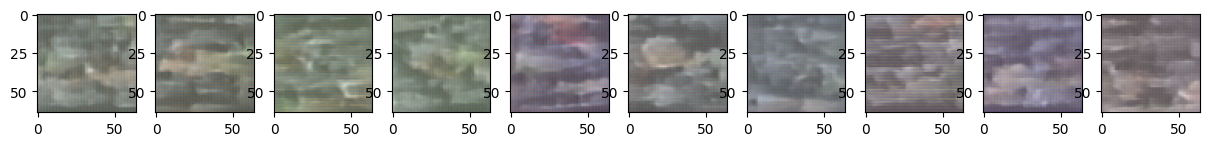

Epoch 160 | step 000 Loss: 0.14417360723018646 


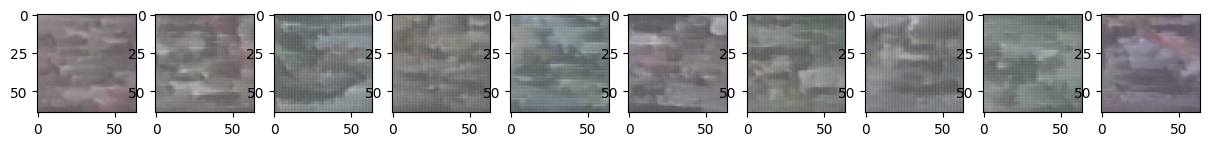

Epoch 180 | step 000 Loss: 0.1422818899154663 


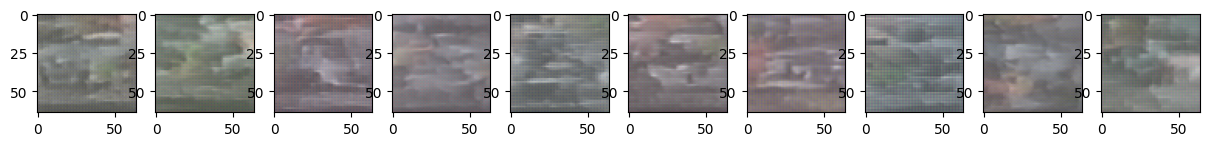

Epoch 200 | step 000 Loss: 0.12909537553787231 


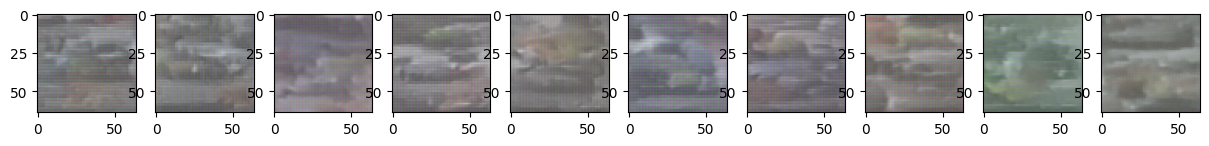

Epoch 220 | step 000 Loss: 0.1375015825033188 


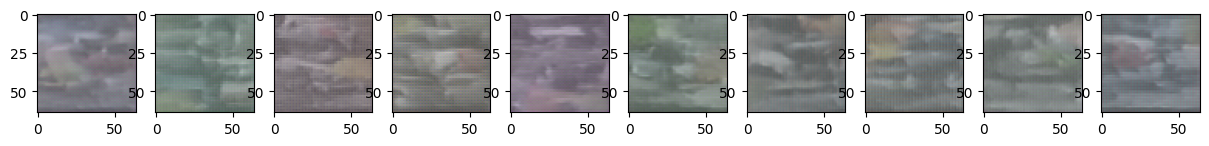

Epoch 240 | step 000 Loss: 0.14363862574100494 


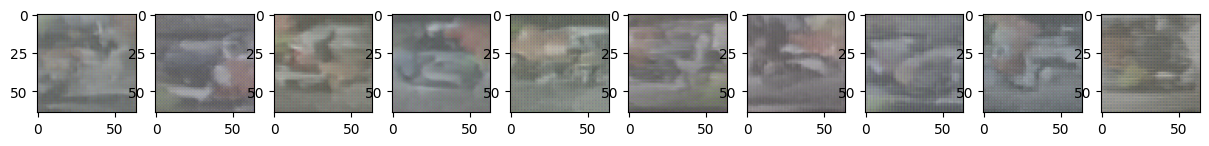

Epoch 260 | step 000 Loss: 0.1436409205198288 


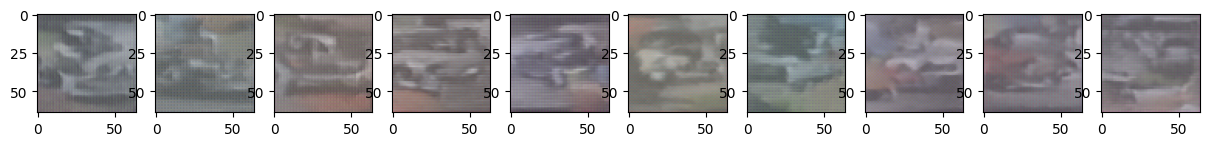

Epoch 280 | step 000 Loss: 0.14226198196411133 


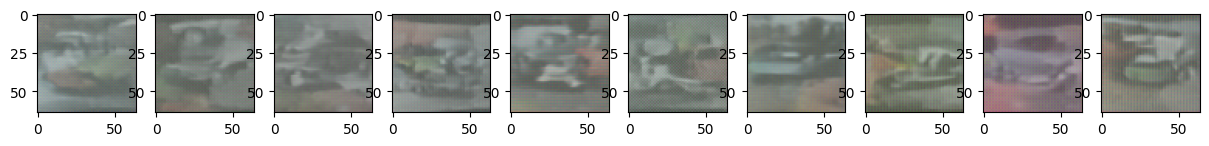

Epoch 300 | step 000 Loss: 0.1432848870754242 


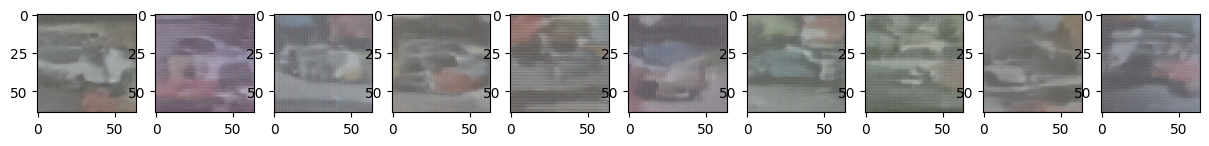

Epoch 320 | step 000 Loss: 0.13751143217086792 


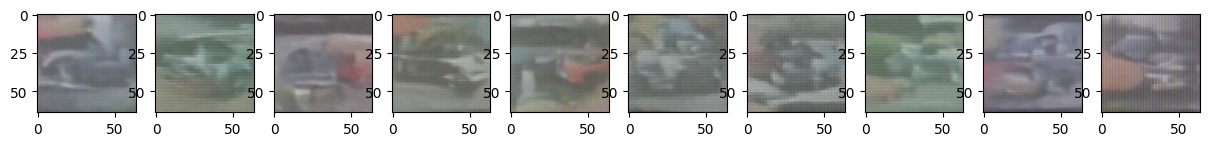

Epoch 340 | step 000 Loss: 0.13578014075756073 


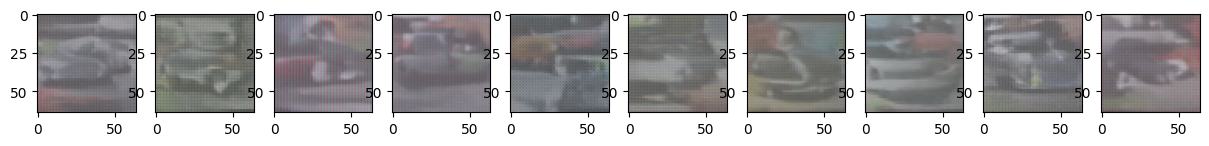

Epoch 360 | step 000 Loss: 0.14160090684890747 


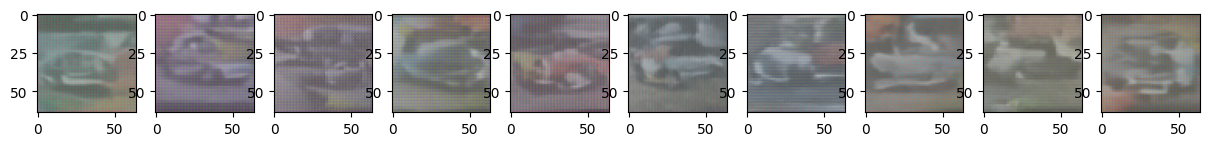

Epoch 380 | step 000 Loss: 0.12958915531635284 


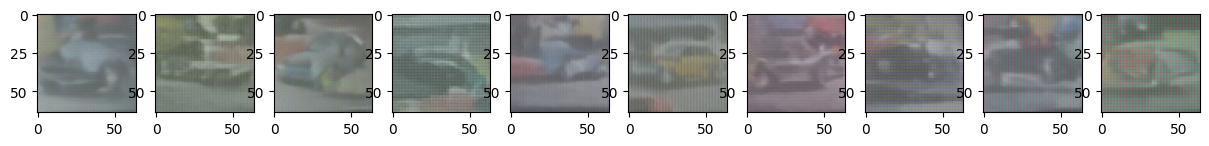

Epoch 400 | step 000 Loss: 0.1399536430835724 


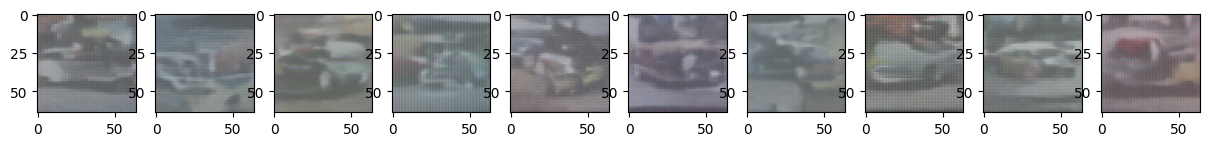

Epoch 420 | step 000 Loss: 0.13998235762119293 


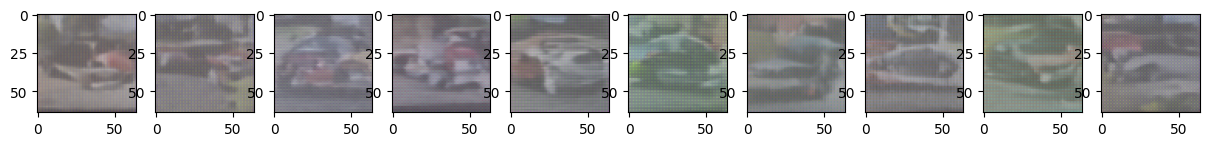

Epoch 440 | step 000 Loss: 0.137372225522995 


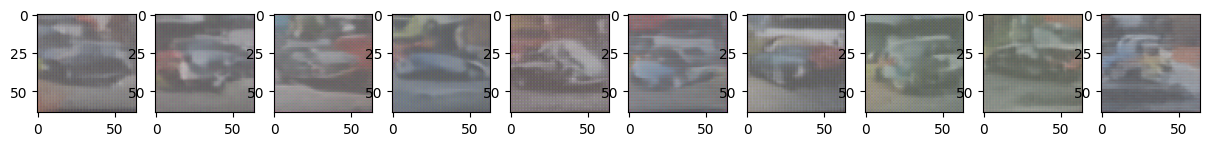

Epoch 460 | step 000 Loss: 0.14471027255058289 


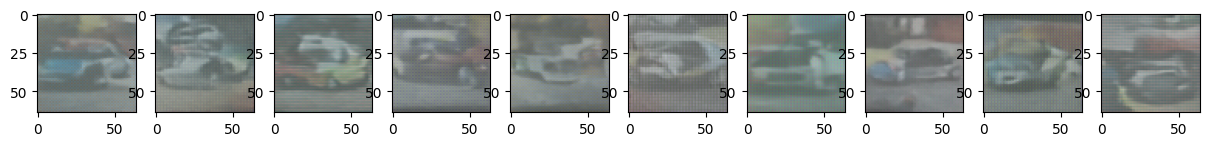

Epoch 480 | step 000 Loss: 0.14016269147396088 


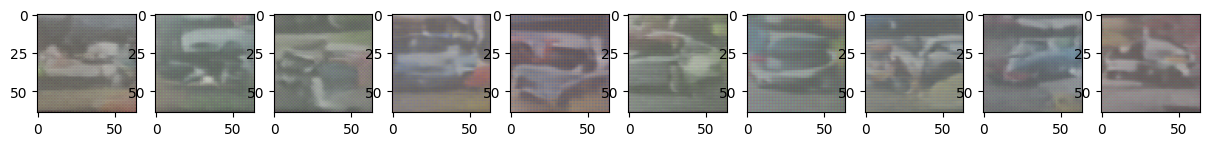

Epoch 500 | step 000 Loss: 0.14703813195228577 


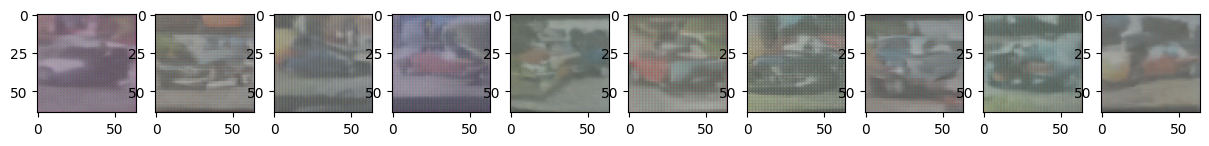

Epoch 520 | step 000 Loss: 0.13047492504119873 


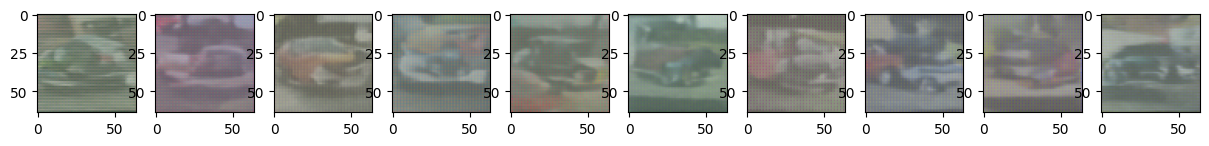

Epoch 540 | step 000 Loss: 0.1259019374847412 


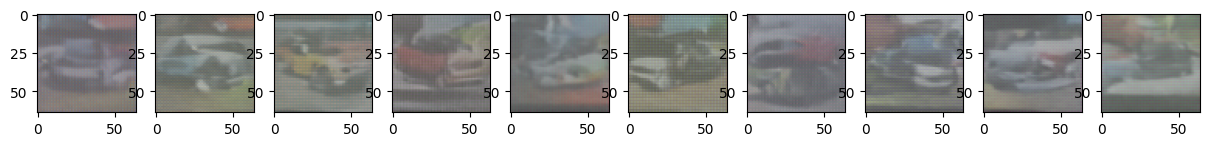

Epoch 560 | step 000 Loss: 0.1287968009710312 


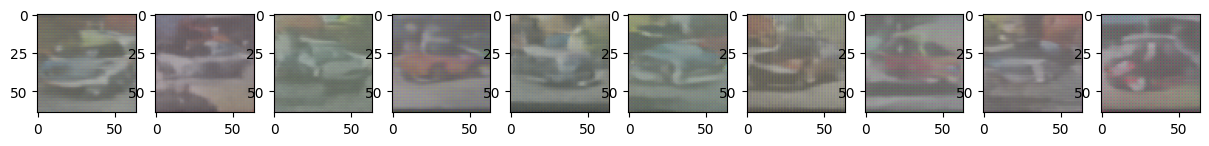

Epoch 580 | step 000 Loss: 0.10886826366186142 


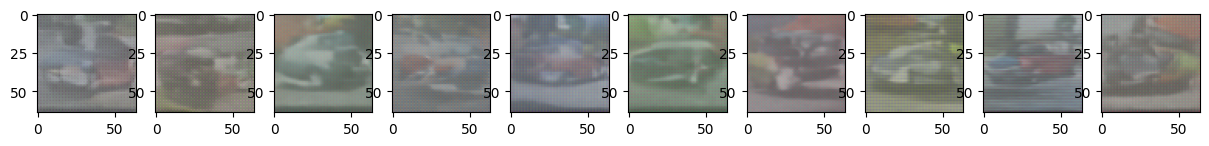

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 600 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):

        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        x_noisy, noise = forward_diffusion_sample(batch[0], t, device) # batch[0] are images, the batch[1] are the labels
        noise_pred = model(x_noisy, t)
        loss = F.l1_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        if epoch % 20 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()